In [118]:
import numpy as np 
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')
data_path='/content/gdrive/MyDrive/EC247/'
    
import sys
sys.path.append(data_path)

from data_init_loading import *
from data_augmenters import *
from architectures import *
from architecture_utils import *

#Pytorch related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


intial data loading which bhai has given some (Tonmoy) --> data_init__loading 

Then there is data_preprocessing/augmentation --> data_augmenters.py (only flippping across time, discussion 9 note book has pipeline we can use that)


architectures.py --> Architectures for models

architectures_utils.py -->


In [4]:
#data_path=r'C:/Users/raksh/Desktop/(EC 247)Neural Network and Deep Learning/Project/project_data_files/'
X_test = np.load(data_path+"X_test.npy")
y_test = np.load(data_path+"y_test.npy")
person_train_valid = np.load(data_path+"person_train_valid.npy")
X_train_valid = np.load(data_path+"X_train_valid.npy")
y_train_valid = np.load(data_path+"y_train_valid.npy")
person_test = np.load(data_path+"person_test.npy")

In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


(529,)
(22, 1000)


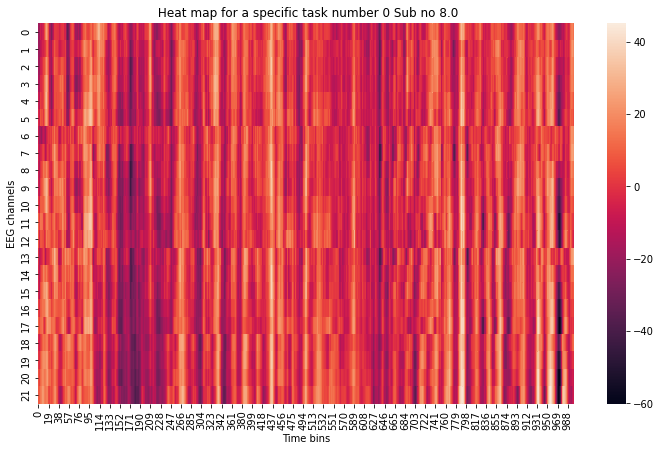

(529,)
(22, 1000)


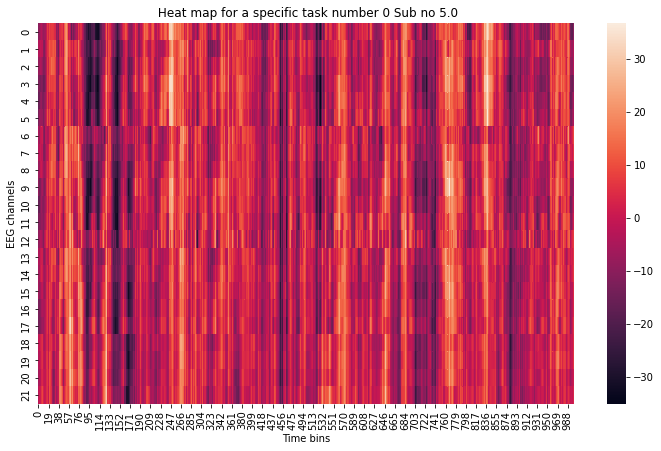

(529,)
(22, 1000)


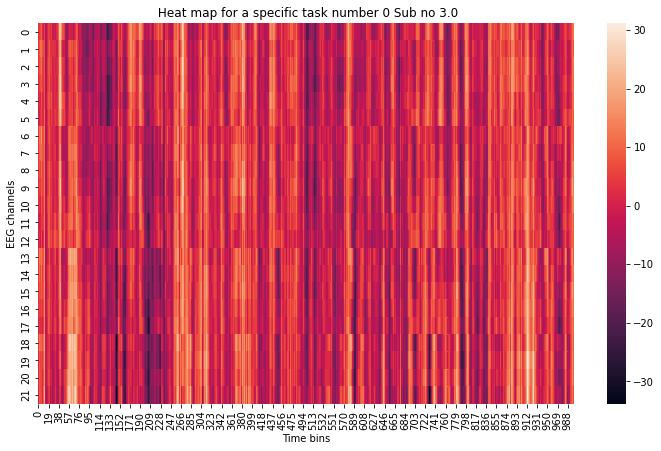

(529,)
(22, 1000)


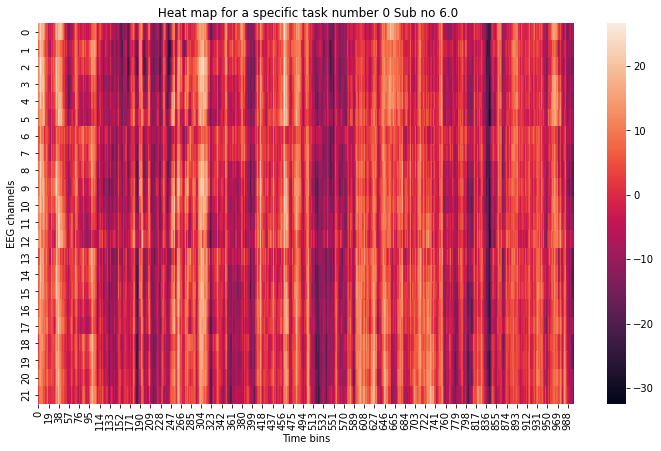

(529,)
(22, 1000)


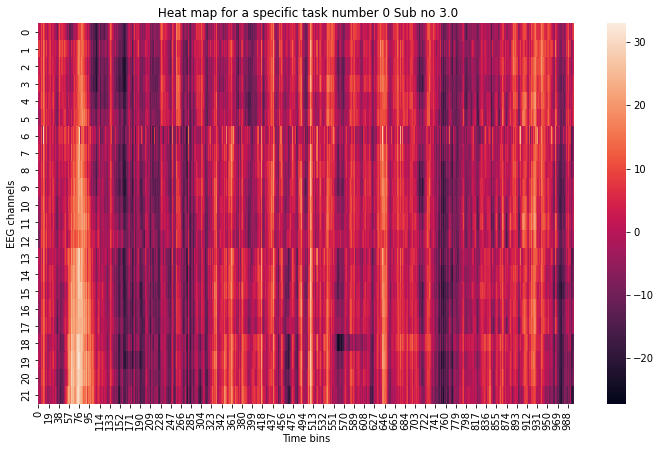

In [6]:
data_loader=data_init_loader()

y_train_valid,y_test=data_loader.make_labels(y_train_valid,y_test)
# Plot heat maps for each tasks
for i in range(5):
    data_loader.visualize_heatmap(X_train_valid,y_train_valid,person_train_valid,task=0)

(513,)
(22, 1000)


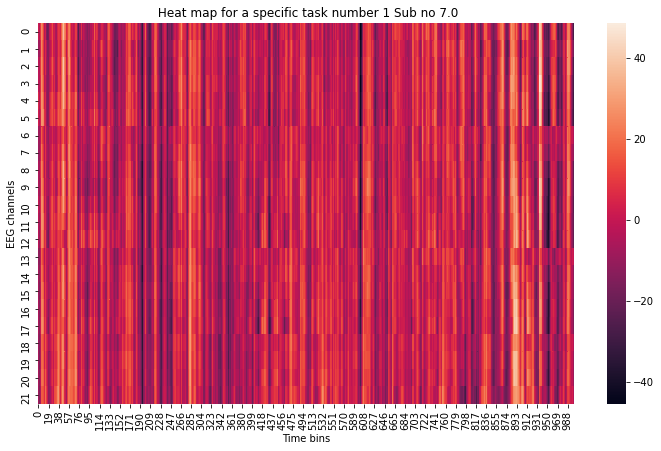

(513,)
(22, 1000)


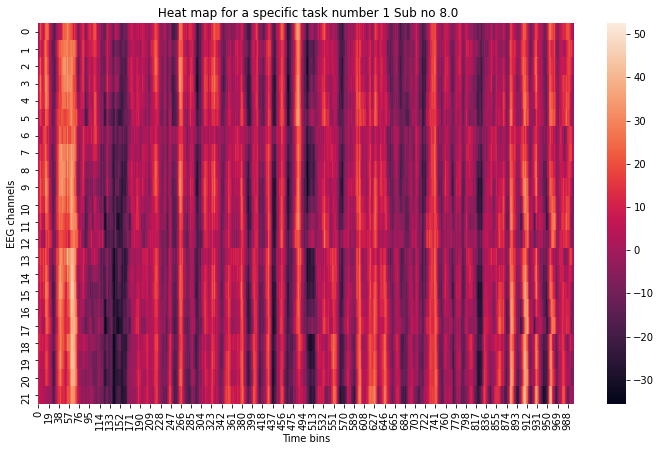

(513,)
(22, 1000)


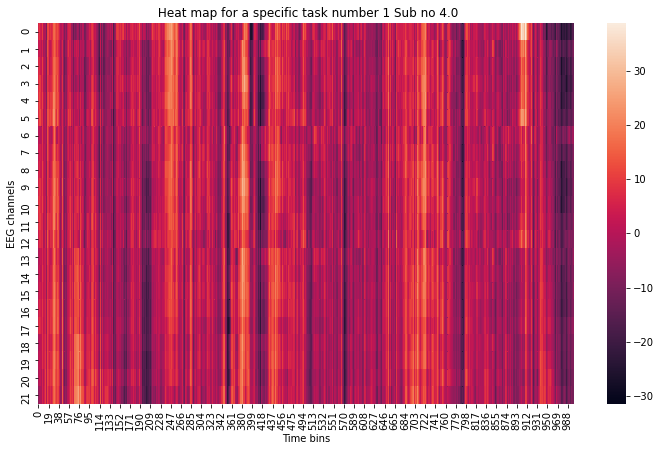

(513,)
(22, 1000)


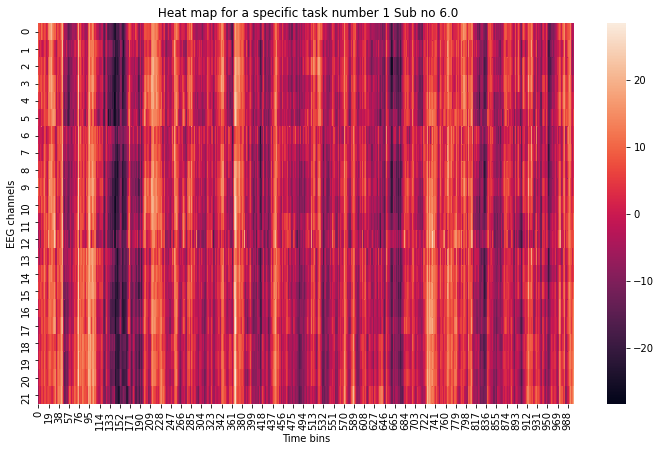

(513,)
(22, 1000)


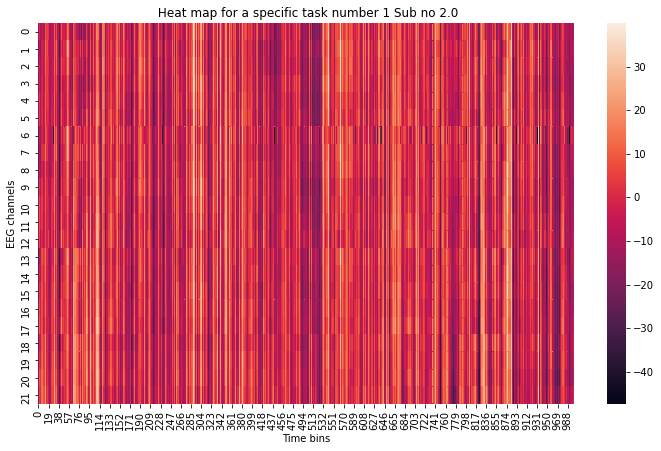

In [ ]:
# Plot heat maps for each tasks
for i in range(5):
    data_loader.visualize_heatmap(X_train_valid,y_train_valid,person_train_valid,task=1)

(513,)
(22, 1000)


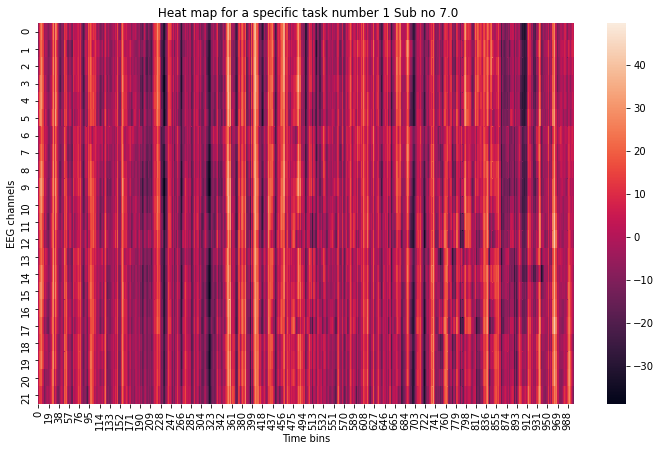

(513,)
(22, 1000)


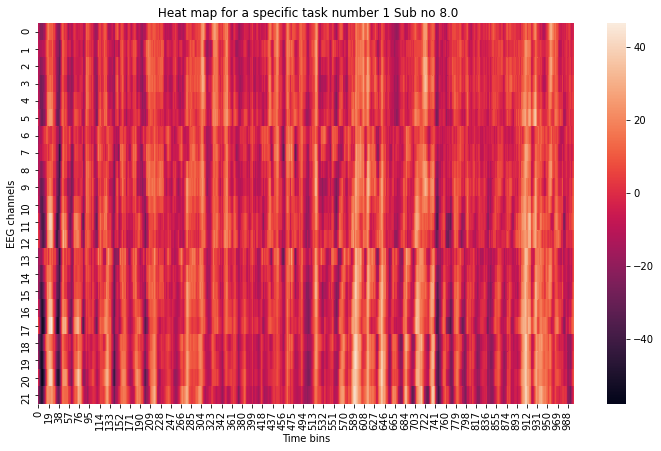

(513,)
(22, 1000)


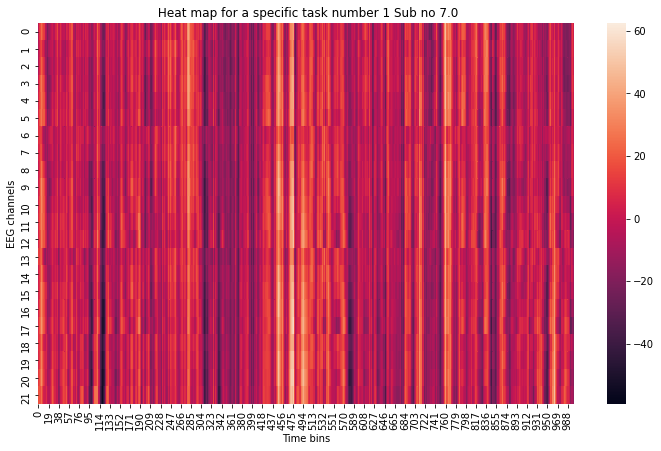

(513,)
(22, 1000)


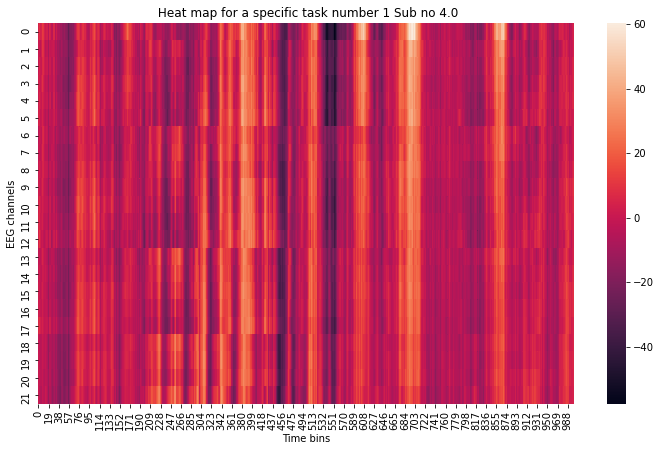

(513,)
(22, 1000)


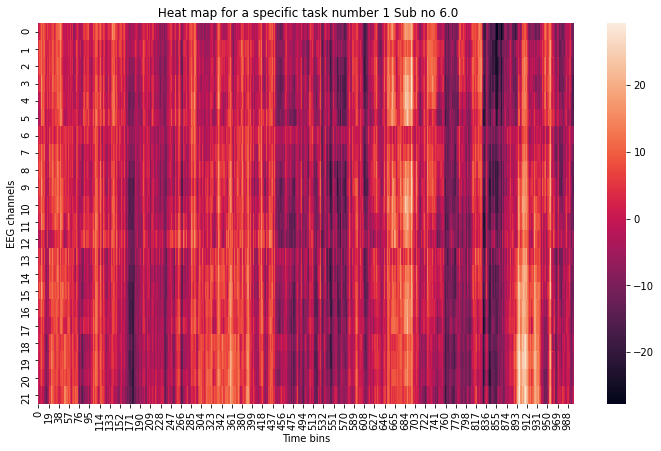

In [ ]:
# Place holder for data augmentation
d_aug=data_augmenter()
X_time_flip,y_time_flip=d_aug.flip_across_time(X=X_train_valid,y=y_train_valid,time_axis=2)

for i in range(5):
    data_loader.visualize_heatmap(X_time_flip,y_time_flip,person_train_valid,task=1)

In [49]:
#Writing my own dataset class that inherits pytorchs dataset class 
# https://pytorch.org/vision/stable/datasets.html
class Dataset(torch.utils.data.Dataset):
  def __init__(self,X,y):
    self.X=torch.from_numpy(X).float()
    self.y=torch.from_numpy(y).long()
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):
    return self.X[index],self.y[index]
  

def torch_data_loader(X_train,y_train,X_test,y_test, X_valid=[], y_valid=[],b_size=64):
  """
  torch_data loader that takes X_train,y_train .... as inputs remember X's here are of shape Numtrails*channels(22)*timebins(1000)
  we convert X to be shape of Numtrails*channels(22)*timebins(1000)*1(this dimension extra)

  This returns 3 data loaders of train,test and validation if valid is not None
  """
  X_train=X_train[:,:,np.newaxis,:]
  X_test=X_test[:,:,np.newaxis,:]
  if len(X_valid)==0:
    pass
  else:
    X_valid=X_valid[:,:,np.newaxis,:]

  
  # The procedure is to first call dataset and then dataloader in pytorch 
  dataset_train=Dataset(X_train,y_train)
  dataloader_train=DataLoader(dataset_train,batch_size=b_size,shuffle=True)

  dataset_test=Dataset(X_test,y_test)
  dataloader_test=DataLoader(dataset_test,batch_size=b_size,shuffle=True)

  if len(X_valid) ==0:
    dataloader_valid=[]
  else:
    dataset_valid=Dataset(X_valid,y_valid)
    dataloader_valid=DataLoader(dataset_valid,batch_size=b_size,shuffle=True)
  
  return dataloader_train,dataloader_test,dataloader_valid


In [112]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules import dropout
# Start training a vanilla LSTM on this data set


#This will go inside modules.py directory 

class LSTM(nn.Module):

  def __init__(self,input_size=22,hid_state=[64,64],num_rnns=2,dropout=0.3,num_classes=4) -> None:
      super(LSTM,self).__init__()
      # nn.LSTM is defined by pytorch already 
      # Please google for definition
      self.lstm_module=nn.LSTM(input_size=input_size,hidden_size=hid_state[0],num_layers=num_rnns,
                               batch_first=True,dropout=0 )
      
      #Fully connected net
      self.fc_module=nn.Sequential(
         nn.Linear(hid_state[0],hid_state[0]),
         nn.ReLU(inplace=True) ,
         nn.BatchNorm1d(num_features=hid_state[0]),
         nn.Dropout(p=dropout),
         nn.Linear(hid_state[0],hid_state[1]),
         nn.ReLU(inplace=True) ,
         nn.BatchNorm1d(num_features=hid_state[1]),
         nn.Dropout(p=dropout),
         nn.Linear(hid_state[1],num_classes)

      )

  def forward(self,X):
    #X inputs are of form X= num_trails*num_channels*1*time_bins( as this format compatible for CNN)
    N,C,H,W=X.size()
    X=X.view(N,C,W)

    # This will give a tensor of shape num_trails*time_bins*input_size
    X=X.permute(0,2,1)
    lstm_out,_=self.lstm_module(X)

    # LSTM output of size
    #Num trials,L(time bins),H(hidden state size)
    fc_out=self.fc_module(lstm_out[:,-1,:])
    return fc_out

In [94]:
#This module would be in model architectures .py

#Ideas from :https://pytorch.org/tutorials/beginner/introyt/trainingyt.html


"""
for i in range(2):

Function to train per epoch it takes model which is a nn.Module() type an optimizer which torch.optim() type
https://pytorch.org/docs/stable/optim.html for more details, Loss function is the default Loss function
Trainining data loader of torch.utils.Data loader type
"""
def train_per_epoch(model,optimizer,train_loader,loss_func=nn.CrossEntropyLoss(),printevery=10):
  
  #put model in train mode
  model.train()
  running_loss=0
  last_loss=0
  # This will go through all the batches each entry in train_loader is a batch 
  for idx,data in enumerate(train_loader):
    
    inputs,labels=data

    #zero out gradients to avoid accumulation
    optimizer.zero_grad();

    # This will call .forward method of your model
    op=model(inputs)

    loss_val=loss_func(op,labels)

    # Do  backward prop
    loss_val.backward()

    #update weights
    optimizer.step()

    # loss.item gives average loss for that batch
    running_loss+=loss_val.item()

    #last_loss is the lass fof last batch
    last_loss=loss_val.item()
    # Print some info for every 10 batches
    
    if (idx%(printevery) == 0):
      print('In training#####:batches completed={}/{}'.format(idx+1,len(train_loader)), 'The value of loss is {}'.format(running_loss/(printevery)))
      running_loss=0

    return model,last_loss



In [113]:
#This module would be in model architectures .py
#just putting model in test mode

def test_model(model,data_loader,loss_func=nn.CrossEntropyLoss(),print_every=10,mode="train"):
  model.eval()
  # This is for each batch
  total_correct=0
  running_loss=0
  last_loss=0
  
  for idx,data in enumerate(data_loader):
    X,y=data
    output_scores=model(X)
    y_maxs,y_pred=torch.max(output_scores.data, 1)
    # Converting everything to numpy arrays 

    y_pred_np=y_pred.cpu().detach().numpy() 
    y_actual_np=y.cpu().detach().numpy()

    total_correct=total_correct+(np.where(y_pred_np==y_actual_np)[0].shape[0])

    running_loss=running_loss+loss_func(output_scores,y).item()
    last_loss=last_loss+loss_func(output_scores,y).item()
    if idx%print_every==0:
      print('batches completed={}/{}'.format(idx+1,len(data_loader)), "The value of loss "+mode+" is {}".format(running_loss/(print_every)))
      print('batches completed={}/{}'.format(idx+1,len(data_loader)), "The value of "+mode+" accuracy is {}".format(accuracy_score(y_actual_np,y_pred_np)))
      running_loss=0
    
    #Returns lastloss and overall accuracy
  return  (last_loss/idx),(total_correct/(len(data_loader.dataset)))
  




In [114]:
# This part of the code trains the model for multiple epochs 
# For each epoch we calculate the testing accuracy and loss so that we dont over fit and identify the correct num of epochs

def train_multi_epochs(model,optimizer,all_data_loader,loss_func=nn.CrossEntropyLoss(),printevery=10,num_epochs=5):
  # We have all data loaders all we do now is train our model for all the epochs and for reach epoch calculate the validation 
  #accuracy/precision, training accuracy and precision

  dataloader_train,dataloader_test,dataloader_valid=all_data_loader
  eval_metrics={}
  eval_metrics['train_loss_hist']=[]
  eval_metrics['train_loss_accuracy']=[]
  eval_metrics['val_loss_hist']=[]
  eval_metrics['test_loss_hist']=[]
  eval_metrics['val_loss_accuracy']=[]
  eval_metrics['test_loss_accuracy']=[]
  max_test_accu=0
  best_model=None

  for i in range(num_epochs):
    model,train_loss=train_per_epoch(model,optimizer,dataloader_train,loss_func,printevery)
    
    train_loss,train_accu=test_model(model,dataloader_train,loss_func,printevery,mode="train")
    eval_metrics['train_loss_hist'].append(train_loss)
    eval_metrics['train_loss_accuracy'].append(train_accu)
    
    if not (len(dataloader_valid)==0):
      val_loss,val_accu=test_model(model,dataloader_valid,loss_func,printevery,mode="validation")
      eval_metrics['val_loss_hist'].append(val_loss)
      eval_metrics['val_loss_accuracy'].append(val_accu)
  
    test_loss,test_accu=test_model(model,dataloader_test,loss_func,printevery,mode="test")
    eval_metrics['test_loss_hist'].append(test_loss)
    eval_metrics['test_loss_accuracy'].append(test_accu)
    
    if test_accu > max_test_accu:
      best_model= model
      max_test_accu=test_accu
    print("Epochs done==============",i+1,"/",num_epochs)
    
  return best_model,max_test_accu,eval_metrics







In [115]:
def plot_train_test_curves(eval_metrics):
  plt.figure(1)
  plt.title("Loss vs num epochs")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  x_range=np.arange(1,len(eval_metrics['test_loss_hist'])+1)
  plt.plot(x_range,eval_metrics['train_loss_hist'], label='Train')
  plt.plot(x_range,eval_metrics['val_loss_hist'], label='Validation')
  plt.plot(x_range,eval_metrics['test_loss_hist'], label='Test')
  plt.legend(loc='best')
  plt.show()

  plt.figure(2)
  plt.title("Accuracy vs num epochs")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  x_range=np.arange(1,len(eval_metrics['test_loss_hist'])+1)
  plt.plot(x_range,eval_metrics['train_loss_accuracy'], label='Train')
  plt.plot(x_range,eval_metrics['val_loss_accuracy'], label='Validation')
  plt.plot(x_range,eval_metrics['test_loss_accuracy'], label='Test')
  plt.legend(loc='best')
  plt.show()





In [116]:
#Demo model which is a LSTM on our input data 

d_init_loader=data_init_loader()
X_train,X_valid,y_train,y_valid,person_train,person_valid=d_init_loader.train_valid_split(X_train_valid,y_train_valid,person_train_valid)

#At this point I have x_train, y_train, test and valid 
#Using the pytorch data loaders to get my things in place
dataloader_train,dataloader_test,dataloader_valid=torch_data_loader(X_train,y_train,X_test,y_test,X_valid,y_valid)

# I have all 3 data loaders now all I need to do is train the model first
all_data_loader=(dataloader_train,dataloader_test,dataloader_valid)

#Before that need to define an optimizer with pytorch and even before that make a model
model_lstm=LSTM()
optimizer=optim.Adam(model_lstm.parameters())
best_model,max_test_accu,eval_metrics=train_multi_epochs(model_lstm,optimizer,all_data_loader)

(1692, 22, 1000) (1692,) (423, 22, 1000) (423,) (1692, 1)
In training#####:batches completed=1/27 The value of loss is 0.14888786077499389
batches completed=1/27 The value of loss train is 0.1401795506477356
batches completed=1/27 The value of train accuracy is 0.1875
batches completed=11/27 The value of loss train is 1.3862363934516906
batches completed=11/27 The value of train accuracy is 0.28125
batches completed=21/27 The value of loss train is 1.3879012227058412
batches completed=21/27 The value of train accuracy is 0.28125
batches completed=1/7 The value of loss validation is 0.1390567898750305
batches completed=1/7 The value of validation accuracy is 0.25
batches completed=1/7 The value of loss test is 0.13920332193374635
batches completed=1/7 The value of test accuracy is 0.203125
Epochs done============== 1 / 5
In training#####:batches completed=1/27 The value of loss is 0.159187388420105
batches completed=1/27 The value of loss train is 0.13833959102630616
batches completed=1

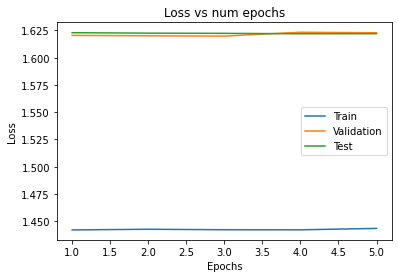

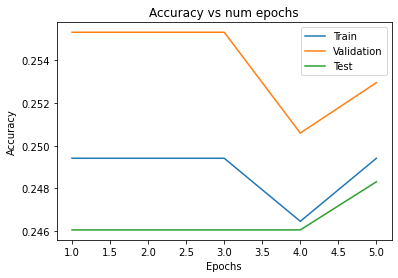

In [117]:
plot_train_test_curves(eval_metrics)